# Training example TPV 13-3D

TPV 13-3D is a benchmark exercise that is designed to test if computer codes that simulate dynamic earthquake rupture are working as intended [(Harris et al., SRL 2018)](https://pubs.geoscienceworld.org/ssa/srl/article/89/3/1146/530061/A-Suite-of-Exercises-for-Verifying-Dynamic). It was designed by the [SCEC/USGS Spontaneous Rupture Code Verification Project](https://strike.scec.org/cvws/) and features:

* spontaneous rupture on a 2D planar 60-degree dipping normal fault  
* homogeneous half-space: $V_p=5716\,m/s, V_s=3300\,m/s, \rho=2700\,kg/m^3$
* non-associative Drucker-Prager plasticity with yielding in shear 
* linear-slip weakening (LSW) friction 
* initial stress conditions are depth-dependent and specified everywhere throughout the entire model volume
* prescribed nucleation zone, square, 3 x 3 km in size, locally lower static coefficient of friction
* strongly supershear rupture conditions

![](tpv13.jpg)

[Detailed benchmark description (SCEC)](https://strike.scec.org/cvws/tpv12_13docs.html).

Note, that for this training we slightly reduced two material constants, the bulk friction and the bulk cohesion, to increase the effects of off-fault yielding.

## Mesh generation

We use the open-source software Gmsh ([http://gmsh.info](http://gmsh.info)) for mesh generation. The following steps are required:

* create a half-space box-shaped domain (box)
* create a 60° dipping rectangular fault plane
* ensure that the mesh explicitly accounts for the nucleation patch at the hypocenter (why? see [Pelties et al., 2014](https://gmd.copernicus.org/articles/7/847/2014/) and [Galis et al., 2015](https://academic.oup.com/gji/article/200/2/890/609776))
* set all required boundary conditions

Gmsh comes with its own scripting language, and provides a [manual](http://gmsh.info/doc/texinfo/gmsh.html) and [tutorial examples](http://gmsh.info/doc/texinfo/gmsh.html#Tutorial). The first step is to build a geometrical (CAD) model, which is then used by the automatic mesh generator.
We use the gmsh script tpv13_training.geo to generate the 3D unstructured tetrahedral mesh in the next step.

In [ ]:
!gmsh -3 tpv13_training.geo -setnumber dip 60
# on Frontera with apptainer, replace with:
# !mpirun apptainer run {"~/my-training.sif"} gmsh -3 tpv13_training.geo

You should now have a file called `tpv13_training.msh`.
In the next step, we translate this file into the efficient HDF5 format, which is going to be read in by SeisSol. HDF5 stands for the Hierarchical Data Format version 5, and is an open-source file format that supports large, complex, heterogeneous data. HDF5 uses a "file directory" like structure that allows you to organize data within the file in many different structured ways, as you might do with files on your computer, and is built for fast I/O processing and storage.

We use our tool pumgen for mesh generation for SeisSol, which is [open-source software](  https://github.com/SeisSol/PUMGen), see also [SeisSol's documentation]( https://seissol.readthedocs.io/en/latest/meshing-with-pumgen.html).

In [ ]:
!mpirun -n 1 pumgen -s msh4 tpv13_training.msh
# on Frontera with apptainer, replace with:
# !mpirun -n 1 apptainer run {"~/my-training.sif"} pumgen -s msh4 tpv13_training.msh

The files `tpv13_training.puml.h5` and `tpv13_training.xdmf` were created.
While the .h5 file is read by SeisSol, the .xdmf file can be used to visualize the mesh, as in the following.

In [ ]:
import vtk
import pyvista as pv

reader = vtk.vtkXdmfReader()
reader.SetFileName('tpv13_training.xdmf')
reader.Update()
mesh = pv.wrap(reader.GetOutput())
pv.plot(mesh, cmap='BuGn', background='white', show_edges=True, jupyter_backend='panel')

Note that the mesh is refined close to the fault.

### Exercises
* Inspect the `tpv13_training.geo` file and try to understand the meshing script. Consult the [Gmsh documentation](https://gmsh.info/doc/texinfo/gmsh.html) about the BooleanFragments operation (which may not be intuitive but is a powerful operation gmsh provides).
* Create a finer resolved mesh by changing the `h_fault` parameter. Do not change the .geo file but use the [`-setnumber PARAMETER VALUE`](https://gmsh.info/doc/texinfo/gmsh.html#Command_002dline-options) command line argument of above *gmsh* command. Try, for example, to mesh the nucleation patch with 300 m and the remaining fault with 600 m element edge length.
* Change the dip of the fault by changing the dip parameter.

## Run SeisSol for a 3D dynamic rupture earthquake scenario with off-fault plastic deformation.

In the following, we start SeisSol using the provided parameter file.
You should adjust the OMP_NUM_THREADS variable to match the number of cores on your PC or laptop.
Note, that on larger clusters SeisSol uses an optimized hybrid MPI + OpenMP parallelization.

In [ ]:
!OMP_NUM_THREADS=4 mpirun -n 1 SeisSol_Release_dhsw_4_elastic parameters.par
# on Frontera with apptainer, replace with:
# !SEISSOL_COMMTHREAD=0 OMP_NUM_THREADS=28 mpirun -n 2 apptainer run {"~/my-training.sif"} SeisSol_Release_dhsw_4_elastic parameters.par

While SeisSol is running, you might want to checkout the [documentation of the input files](https://seissol.readthedocs.io/en/latest/parameter-file.html).

## Visualization

We now visualize the fault output generated by SeisSol.
Check out the [documentation](https://seissol.readthedocs.io/en/latest/fault-output.html#outputmask) for an explanation of which output field each abbreviation means.

In [ ]:
from ipywidgets import interact

reader = vtk.vtkXdmfReader()
reader.SetFileName('output/tpv13-fault.xdmf')
reader.Update()
cd = reader.GetOutput().GetCellData()
variables = [cd.GetArrayName(i) for i in range(cd.GetNumberOfArrays())]

@interact(t=(0.0, 8.0, 1.0), var=variables)
def plot(t=0.0, var='SRd'):
    reader.UpdateTimeStep(t)
    mesh = pv.wrap(reader.GetOutput())
    plotter = pv.Plotter(notebook=True)
    plotter.set_background('white')
    #fix color range for rupture speed
    clim_arg = {"clim":(0, 6000)} if var=='Vr' else {}
    plotter.add_mesh(mesh, cmap='Blues', scalars=var, **clim_arg)
    plotter.view_xz()
    plotter.show(jupyter_backend='panel')
    plotter.close()

The above visualization is based on ```pyvista``` and ```ipywidgets```, whose rendoring is not well supported inside the container. We show a simpler way of quick visualization of the results. It also comes with fewer non-standard python3 dependencies.

In [4]:
import numpy as np
from matplotlib import pyplot as plt

import seissolxdmf as seisx
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors

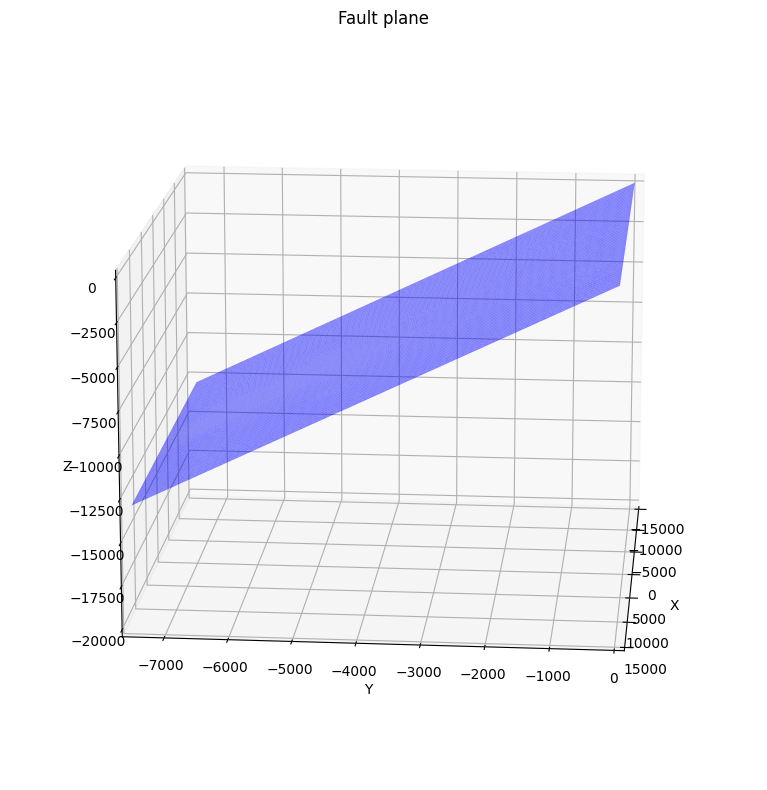

In [18]:
# Load data
xdmfFilename = "output_tpv13/tpv13-fault.xdmf"
sx = seisx.seissolxdmf(xdmfFilename)
ndt = sx.ReadNdt() - 1
xyz = sx.ReadGeometry()
connect = sx.ReadConnect()

# Extract vertices for each triangular face in the mesh
triangles = [xyz[connect[i]] for i in range(connect.shape[0])]

# Prepare data for the triangles
verts = [tri for tri in triangles]

# Create subplots
fig = plt.figure(figsize=(16, 8))

# First subplot: Slip Rate
ax1 = fig.add_subplot(111, projection='3d')
sRate_collection = Poly3DCollection(verts, alpha=0.5, facecolor='blue')
ax1.add_collection3d(sRate_collection)
ax1.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax1.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax1.set_zlim(-20e3, 0)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('Fault plane')

# Adjust view angles
ax1.view_init(elev=15, azim=5)

plt.tight_layout()
plt.show()


# Initial stress and fault strength

The loading in tpv13 is defined as a stress tensor, which is converted into fault tractions by SeisSol.
In the next cell, we compute analytically the normal and shear tractions, and compute the relative prestress ratio, a key parameter for rupture dynamics, characterizing the initial stress.
By modifying params with the nucleation static friction (mu_s=0.54), verify that this area is critically stressed (R>1).

In [ ]:
import sympy as sp
import numpy as np

# Define symbolic variables
s3_to_s1, sigma_max, dip, mu_s, mu_d = sp.symbols("s3_to_s1 sigma_max dip mu_s mu_d")

# stress tensor
stress = sp.diag((1 + s3_to_s1) * sigma_max / 2, s3_to_s1 * sigma_max, sigma_max)
# normal and along dip unit vectors
u_n = sp.Matrix([0, -sp.sin(dip), sp.cos(dip)])
udip = sp.Matrix([0, sp.cos(dip), sp.sin(dip)])

# tractions
traction = stress * u_n

sigma_n = traction.dot(u_n)
print("sigma_n:", sigma_n)
sigma_d = traction.dot(udip)
print("sigma_d:", sigma_d)

R = (sigma_d - mu_d * sigma_n) / ((mu_s - mu_d) * sigma_n)
print("relative prestress ratio R:", R)

params = {"dip": 60 * np.pi / 180, "s3_to_s1": 0.3495, "mu_s": 0.7, "mu_d": 0.1}
print(
    f"relative prestress ration R evaluated with {params}:",
    R.subs(params),
)

print("sigma_n:", sigma_n.subs(params))
print("sigma_d:", sigma_d.subs(params))

# Rupture speed analysis

We analyze the mechanism causing supershear in this setup and disable it.

* Examine the earthquake rupture speed and identify the conditions that trigger supershear rupture.
* Change the nucleation size from 3 to 1.2km in both `tpv12_13_fault.yaml` (update parameters nucleation_size) and `tpv13_training.geo` (update parameters `l_n` and `w_n`) to disable the current supershear triggering mechanism.
* You should now observe a delay in the supershear transition.
* Verify that you can suppress the supershear transition mechanism by decreasing the initial shear stress, that is changing `s3_to_s1` from 0.3495 to 0.4 in `tpv12_13_initial_stress.yaml` and reenabling nucleation by decreasing `mu_s` in the nucleation area from 0.54 to 0.43 and increasing nucleation size from 1.2 to 1.8 km (in `tpv12_13_fault.yaml` and `tpv13_training.geo`).

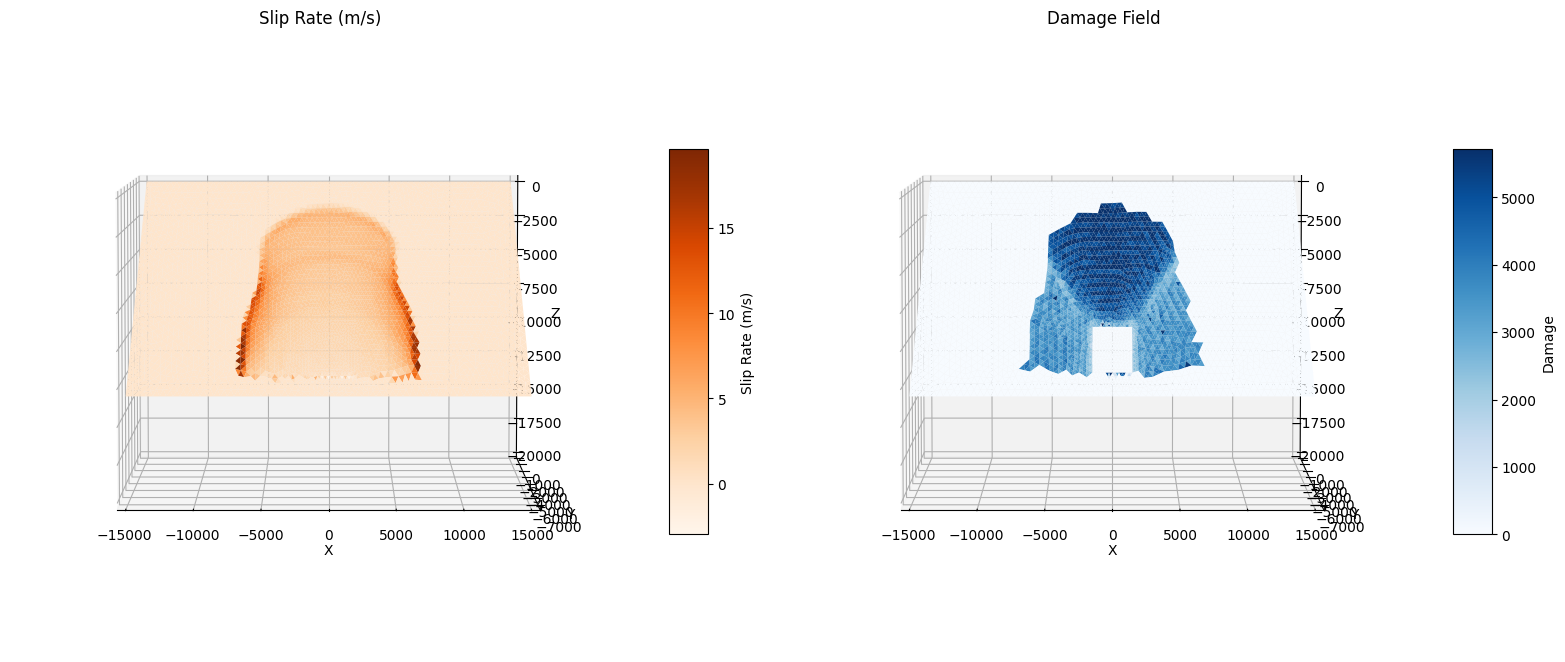

In [7]:
# Load data
xdmfFilename = "output_tpv13/tpv13-fault.xdmf"
sx = seisx.seissolxdmf(xdmfFilename)
ndt = sx.ReadNdt() - 1
xyz = sx.ReadGeometry()
connect = sx.ReadConnect()
ndt = 2
sRate = sx.ReadData('SRd', ndt)
damage = sx.ReadData('Vr', ndt)

# Define the colormap ranges
sRate_vmin, sRate_vmax = np.min(sRate), np.max(sRate)
sRate_norm = mcolors.Normalize(vmin=sRate_vmin, vmax=sRate_vmax)

damage_vmin, damage_vmax = 0, 5714
damage_norm = mcolors.Normalize(vmin=damage_vmin, vmax=damage_vmax)

# Extract vertices for each triangular face in the mesh
triangles = [xyz[connect[i]] for i in range(connect.shape[0])]

# Prepare data for the triangles
verts = [tri for tri in triangles]
sRate_colors = [plt.cm.Oranges(sRate_norm(np.mean(sRate[i]))) for i in range(len(verts))]
damage_colors = [plt.cm.Blues(damage_norm(np.mean(damage[i]))) for i in range(len(verts))]

# Create subplots
fig = plt.figure(figsize=(16, 8))

# First subplot: Slip Rate
ax1 = fig.add_subplot(121, projection='3d')
sRate_collection = Poly3DCollection(verts, alpha=1.0, facecolor=sRate_colors)
ax1.add_collection3d(sRate_collection)
ax1.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax1.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax1.set_zlim(-20e3, 0)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Slip Rate (m/s)')
sm1 = plt.cm.ScalarMappable(cmap='Oranges', norm=sRate_norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('Slip Rate (m/s)')

# Second subplot: Damage
ax2 = fig.add_subplot(122, projection='3d')
damage_collection = Poly3DCollection(verts, alpha=1.0, facecolor=damage_colors)
ax2.add_collection3d(damage_collection)
ax2.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax2.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax2.set_zlim(-20e3, 0)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Damage Field')
sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=damage_norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('Damage')

# Adjust view angles
ax1.view_init(elev=5, azim=270)
ax2.view_init(elev=5, azim=270)

plt.tight_layout()
plt.show()


# Fault-dip dependence of rupture dynamics and ground deformation exercise
Now we compare the subsidence and uplift of dynamic rupture earthquake scenarios varying the dip of the fault

To do so, perform the following steps:  
* Generate a new mesh with an alternative dip angle of your choice. In addition to the mesh, don't forget to update the dip value in `tpv12_13_fault.yaml`, and adapt `mu_s` for the nucleation to remain overstressed (use the python code in the section "Initial stress").
* Run a new simulation using the same command as above but with its output saved in a different folder, and change the prefix that all files will have (`OutputFile`) in the `&Output` namelist 
* Add the new prefix to the `prefixList` of the code block below
* Analyse differences using the visualisation widget above and the cross-sections of surface displacements below


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

prefixList = ['tpv13']
nSim = len(prefixList)
# coordinates of the line end points
a = [0, -10e3, 0]
b = [0, 10e3, 0]
# create line polydata for vizualizing
line = pv.Line(a, b)
p = pv.Plotter(shape=(1, nSim), notebook=True, window_size=[1200, 500])

def load_mesh(prefix):
    # Read free-surface output data
    reader = vtk.vtkHDFReader()
    reader.SetFileName(f'output/{prefix}-free-surface-4.vtkhdf')
    reader.Update()
    return pv.wrap(reader.GetOutput())

# plot the line of the elevation profile over the surface displacement 
for i, pref in enumerate(prefixList):
    mesh = load_mesh(pref)
    p.subplot(0, i)
    p.add_text(pref, font_size=10, position="upper_left")
    p.set_background('lightgrey')
    p.add_mesh(mesh, scalars='u3')
    p.add_mesh(line, color="white", line_width=10)
    p.add_point_labels(
        [a, b], ["A", "B"], font_size=20, point_color="red", text_color="red"
    )
    p.camera.zoom(3)
p.show(jupyter_backend='panel')
p.close()

# plot fault output
p = pv.Plotter(shape=(1, nSim), notebook=True, window_size=[1200, 350])
for i, pref in enumerate(prefixList):
    reader = vtk.vtkXdmfReader()
    reader.SetFileName(f'output/{pref}-fault.xdmf')
    reader.Update()
    reader.UpdateTimeStep(9)
    mesh = pv.wrap(reader.GetOutput())
    p.subplot(0, i)
    p.add_text(pref, font_size=10, position="upper_left")
    p.set_background('white')
    p.add_mesh(mesh, cmap='plasma', scalars="ASl")
    p.view_xz()
    p.camera.zoom(1.6)  
p.show(jupyter_backend='panel')
p.close()

# plot subsidence/uplift profiles
def plot_combined_profiles(prefixList, a, b, resolution=10000):
    plt.figure(figsize=(6, 4))
    for prefix in prefixList:
        mesh = load_mesh(prefix)
        sampled_data = mesh.sample_over_line(a, b, resolution=resolution)
        distance = sampled_data['Distance']
        displacement = sampled_data['u3']
        plt.plot(distance/1000, displacement, label=prefix, linewidth=2)
    plt.axhline(y=0,color='k', linestyle='--', linewidth=0.5)
    plt.title("Comparison of subsidence/uplift profiles")
    plt.xlabel("Distance (km)")
    plt.ylabel("Vertical Displacement (m)")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_combined_profiles(prefixList, a, b)

# plot moment rate release
fig, ax = plt.subplots(figsize=(6, 4))
for i, pref in enumerate(prefixList):
    df = pd.read_csv(f'output/{pref}-energy.csv')
    df = df.pivot_table(index="time", columns="variable", values="measurement")
    df["seismic_moment_rate"] = np.gradient(df["seismic_moment"], df.index[1])
    ax.plot(df.index, df["seismic_moment_rate"], label=pref)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Seismic moment rate (Nm/s)')
ax.set_title('Seismic moment rate comparison')
ax.legend()
plt.show()

## Visualization with Paraview

You can also visualize the SeisSol output in Paraview on your local machine. For that, you have to copy the files from your Docker container. 

The following commands allow you to copy the simulation output from docker to the native filesystem of your machine. Type the commands in the terminal of your local machine: 



In [ ]:
# Execute on your local machine, not within this notebook!

export my_docker=$(docker ps --format "{{.Names}}")

docker cp ${my_docker}:/home/training/tpv13/output .

To visualize the copied SeisSol output, open your Paraview and follow these steps: 

* Click on 1) in the upper left corner
* Choose the xdmf file you want to open and click *ok*
* Choose *XDMF Reader* and click the *ok* button
* The output file will appear in the left bar below *Pipeline Browser*. 
Further down, in *Properties*, the *Apply-button* 2) should have turned green. Click on that button to read in the data.
* With 3) you can choose the property you want to display. If you choose *ASL*, the fault slip will be shown.
* With 4) you can switch to the last timestep. With the arrows you can switch back and forth, or you can choose a specific timestep by typing a *time*. 
* 5) adjusts the colorscale automatically to the data range. 
* With 6) you can change the properties of your color scale (i.e. color, range, log scale). 

![](paraview.jpg)


# Local-time stepping exercises

One of the key features of SeisSol is an efficient local-time stepping scheme, which clusters elements with similar time steps. This method pays off for applications featuring big differences in element sizes, caused by geometric complexity ([Ulrich et al., 2021](https://eartharxiv.org/repository/view/39/)) and/or multi-physics such as fully coupled seismic-acoustic-tsunami simulations ([Krenz et al., 2021](https://arxiv.org/abs/2107.06640)) or poroelastic wave propagation ([Wolf et al., 2021](https://arxiv.org/abs/2108.10565)).  

A time-step cluster $c \in \mathbb{N}_0$ has the time-step
$$\Delta t_c = r^c \Delta t_{\text{min}},$$
where the rate $r \in \mathbb{N}$. In the parameter file the rate $r$ can be set with the *ClusteredLTS* parameter.

* Run SeisSol once with rate-2 local time-stepping (LTS) and once with global time-stepping (GTS).
* In the log, look for "Elapsed time (via clock_gettime)" for both LTS and GTS.
* Compute the speed-up and compare it to the theoretical speed-up due to LTS.

*Hint:* You may reduce the *EndTime* parameter for this exercise.